## A Brief Introduction to Biotite

This notebook provides a brief introduction to Biotite, which is, IMHO, the best package currently available for processing protein (and protein-ligand) structures. In this notebook we will cover the following topics. 
- Reading Files
- Getting Residue Information
- Extracting Ligands From PDB Files - interfacing Biotite with the RDKit
- Getting a Protein Sequence From a Protein Structure
- Getting a Protein Sequence From the PDB
- Aligning Protein Sequences

We begin by installing the necessary Python libraries

In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !uv pip install biotite rdkit numpy

In [2]:
import biotite.structure.io.pdbx as pdbx  # read and write PDB and CIF files
import biotite.database.rcsb as rcsb      # download data from the RCSB PDB
import biotite.structure.info as info     # get information on residues, etc
from biotite.interface import rdkit       # interface with the RDKit
import biotite.sequence as seq            # sequence information
import biotite.structure as struc         # structure information
import biotite.sequence.io.fasta as fasta # FASTA sequence data
import biotite.sequence.align as align    # sequence alignment

from rdkit import Chem                    # chemical structure and data processing
from rdkit.Chem import rdDepictor         # drawing chemical structures
import numpy as np                        # array and matrix manipulation

### Reading Files
To begin, we will download a file from the pdb.  It's 2025, and we shouldn't be working with PDB files.  If you use CIF files instead, your life will be much better. 

In [3]:
pdb_id = '1bmk'
file_path = rcsb.fetch(pdb_id, 'cif', target_path='.')

We can read the cif file into an atom_array.  This is convenient because the data is held in numpy arrays. 

In [4]:
pdbx_file = pdbx.CIFFile.read(file_path)
atom_array = pdbx.get_structure(pdbx_file, model=1, include_bonds=True)

Let's look at the first atom

In [5]:
atom_array[0]

Atom(np.array([28.43 ,  4.029, 23.394], dtype=float32), chain_id="A", res_id=4, ins_code="", res_name="GLU", hetero=False, atom_name="N", element="N")

### Getting Residue Information

We can use the standard numpy mechanisms to process this data. For instance, we can get the unique residue names in the structure. 

In [6]:
names_1bmk = np.unique(atom_array.res_name)
names_1bmk

array(['ALA', 'ARG', 'ASN', 'ASP', 'CYS', 'GLN', 'GLU', 'GLY', 'HIS',
       'HOH', 'ILE', 'LEU', 'LYS', 'MET', 'PHE', 'PRO', 'SB5', 'SER',
       'THR', 'TRP', 'TYR', 'VAL'], dtype='<U5')

At this point, I'd like to know which residues are not standard amino acids (e.g. ligands).  We can use the biotite's sequence module to get this information.  In the code block below, we will do the following. 
- Create a protein sequence object
- Ask the protein sequence object for its alphabet.  This is the 1-letter abbreviations for amino acids.
- Convert the 1-letter abbreviations to 3-letter abbreviations. 

In [7]:
prot_seq = seq.ProteinSequence()
aa_alphabet = prot_seq.get_alphabet()
aa_names = [prot_seq.convert_letter_1to3(x) for x in aa_alphabet]

Now we can use a simple list comprehension to find residues that are not standard amino acids.  It turns out that we have two.
- HOH - water
- SB5 - the ligand

In [8]:
[x for x in names_1bmk if x not in aa_names]

[np.str_('HOH'), np.str_('SB5')]

Now that we know that ligand is **SB5**, let's find out more about the ligand.  We can use [biotite.structure.info](https://www.biotite-python.org/latest/apidoc/biotite.structure.info.html) to look up the canonical structure based on a residue id. We can also use [biotite.interface.rdkit.to_mol](https://www.biotite-python.org/latest/apidoc/biotite.interface.rdkit.html) function to convert a biotite `atom_array` to an [RDKit molecule object](https://www.rdkit.org/docs/source/rdkit.Chem.rdchem.html). 

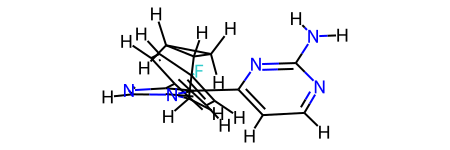

In [9]:
res_sb5 = info.residue("SB5")
ref_mol_sb5 = rdkit.to_mol(res_sb5)
ref_mol_sb5

The canonical residue has 3D coordinates and explicit hydrogens, so it's difficult to understand. We can use the RDKit to calculate 2D coordinates and remove the explicit hydrogens. 

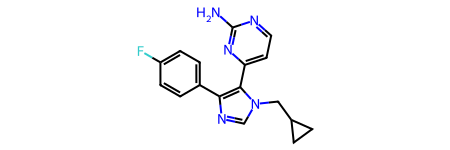

In [10]:
rdDepictor.SetPreferCoordGen(True)
ref_mol_sb5 = Chem.RemoveHs(ref_mol_sb5)
rdDepictor.Compute2DCoords(ref_mol_sb5)
ref_mol_sb5

### Extracting a Ligand From a Protein Structure

In many cases, we want to extract a the ligand structure from a protein structures. With Biotite, we can extract specific residues from a protein-ligand complex. Now that we know that the ligand is residue **SB5**, we can extract that residue.  For simplicity, we will only extract residue **SB5** from chain **A**.  To extract atoms, we first apply a mask.  Then the mask is used as an index into the atom_array.  In the cell below we use the `&` operator to take the intersection of two masks, one that selects `residue_name` **SB5** and another that selects `chain_id` **A**.

In [11]:
mask_sb5 = (atom_array.res_name == 'SB5') & (atom_array.chain_id == 'A')
sb5_atom_array = atom_array[mask_sb5]

As above, we can then convert the atom_array into an RDKit molecule. 

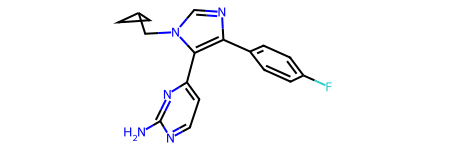

In [12]:
pdb_mol_sb5 = rdkit.to_mol(sb5_atom_array)
pdb_mol_sb5

Now let's compare the canonical structure for SB5 with the one in 1BMK.  First we'll do this by comparing the SMILES. Notice that there's a difference due to explicit single bonds being defined in the canonical reference structure. 

In [13]:
print(Chem.MolToSmiles(ref_mol_sb5),Chem.MolToSmiles(pdb_mol_sb5))
Chem.MolToSmiles(ref_mol_sb5) == Chem.MolToSmiles(pdb_mol_sb5)

Nc1nccc(-c2c(-c3ccc(F)cc3)ncn2CC2CC2)n1 Nc1nccc(c2c(c3ccc(F)cc3)ncn2CC2CC2)n1


False

This another good reason to **not** use SMILES to determine whether two structures are equivalent.  The [InChI key](https://en.wikipedia.org/wiki/International_Chemical_Identifier) is much better choice, because InChI normalizes tautomeric forms.  Notice that the InChI keys for the two molecules are the same. 

In [14]:
print(Chem.MolToInchiKey(ref_mol_sb5),Chem.MolToInchiKey(pdb_mol_sb5))
Chem.MolToInchiKey(ref_mol_sb5) == Chem.MolToInchiKey(pdb_mol_sb5)

DFEYXQGDDCDXJK-UHFFFAOYSA-N DFEYXQGDDCDXJK-UHFFFAOYSA-N


True

Biotite also has a range of methods for dealing with protein sequences.  In the cells below we'll see how we get a sequence from a structure or from the PDB.  We will extract the sequence of the kinase p38$\alpha$ from the 1BMK structure.  Next we will get the sequence of p38$\gamma$ from the PDB and perform a sequence alignment on the two. 

### Getting a Protein Sequence From a Protein Structure
In the cell below we use [biotite.strucure](https://www.biotite-python.org/latest/tutorial/structure/index.html) to get the protein sequence for p38$\alpha$ from the 1BMK structure. 

In [15]:
chain_A_mask = atom_array.chain_id == "A"
protein_mask = struc.filter_amino_acids(atom_array)
protein = atom_array[protein_mask & chain_A_mask]
sequences = struc.to_sequence(protein)
seq_1bmk_A = "".join(sequences[0][0])
seq_1bmk_A

'ERPTFYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGHRVAVKKLSRPFQSIIHAKRTYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMGADLNNIVKCQKLTDDHVQFLIYQILRGLKYIHSADIIHRDLKPSNLAVNEDCELKILDFGLARHTDDEMTGYVATRWYRAPEIMLNWMHYNQTVDIWSVGCIMAELLTGRTLFPGTDHIDQLKLILRLVGTPGAELLKKISSESARNYIQSLAQMPKMNFANVFIGANPLAVDLLEKMLVLDSDKRITAAQALAHAYFAQYHDPDDEPVADPYDQSFESRDLLIDEWKSLTYDEVISFVPPPLD'

### Getting a Protein Sequence From the PDB
In the cell below, we use [biotite.database.rcsb] to get the sequence for a p38$\gamma$ structure.  Note that we could have also obtained a sequence from NCBI Entrez using [biotite.database.entrez](https://www.biotite-python.org/latest/apidoc/biotite.database.entrez.html#module-biotite.database.entrez). Biotite also has interfaces to [PubChem](https://www.biotite-python.org/latest/apidoc/biotite.database.pubchem.html#module-biotite.database.pubchem), [UniProt](https://www.biotite-python.org/latest/apidoc/biotite.database.uniprot.html#module-biotite.database.uniprot) and the [AlphaFold Database](https://www.biotite-python.org/latest/apidoc/biotite.database.afdb.html#module-biotite.database.afdb).

In [16]:
fasta_path = rcsb.fetch("1cm8", "fasta")
fasta_file = fasta.FastaFile.read(fasta_path)
for header, sequence in fasta_file.items():
    seq_1cm8 = sequence
    break
seq_1cm8

'MSSPPPARSGFYRQEVTKTAWEVRAVYRDLQPVGSGAYGAVCSAVDGRTGAKVAIKKLYRPFQSELFAKRAYRELRLLKHMRHENVIGLLDVFTPDETLDDFTDFYLVMPFMGTDLGKLMKHEKLGEDRIQFLVYQMLKGLRYIHAAGIIHRDLKPGNLAVNEDCELKILDFGLARQADSEMTGYVVTRWYRAPEVILNWMRYTQTVDIWSVGCIMAEMITGKTLFKGSDHLDQLKEIMKVTGTPPAEFVQRLQSDEAKNYMKGLPELEKKDFASILTNASPLAVNLLEKMLVLDAEQRVTAGEALAHPYFESLHDTEDEPQVQKYDDSFDDVDRTLDEWKRVTYKEVLSFKPPRQLGARVSKETPL'

### Aligning Sequences
With the two sequences in hand, let's align them and determine their sequence identity. 

In [17]:
p38_alpha_seq = seq.ProteinSequence(seq_1bmk_A)
p38_gamma_seq = seq.ProteinSequence(seq_1cm8)
matrix = align.SubstitutionMatrix.std_protein_matrix()
alignments = align.align_optimal(p38_alpha_seq, p38_gamma_seq, matrix)

In [18]:
best_alignment = alignments[0]

# Calculate Sequence Identity
# This returns a float between 0.0 and 1.0
identity = align.get_sequence_identity(best_alignment)

# Output results
print(f"Sequence Identity: {identity:.2%}") # Formatted as percentage
print("\nAlignment:")
print(best_alignment)


Sequence Identity: 61.16%

Alignment:
-ERP----T-FYRQELNKTIWEVPERYQNLSPVGSGAYGSVCAAFDTKTGHRVAVKKLSRPFQSIIHAKR
MSSPPPARSGFYRQEVTKTAWEVRAVYRDLQPVGSGAYGAVCSAVDGRTGAKVAIKKLYRPFQSELFAKR

TYRELRLLKHMKHENVIGLLDVFTPARSLEEFNDVYLVTHLMGADLNNIVKCQKLTDDHVQFLIYQILRG
AYRELRLLKHMRHENVIGLLDVFTPDETLDDFTDFYLVMPFMGTDLGKLMKHEKLGEDRIQFLVYQMLKG

LKYIHSADIIHRDLKPSNLAVNEDCELKILDFGLARHTDDEMTGYVATRWYRAPEIMLNWMHYNQTVDIW
LRYIHAAGIIHRDLKPGNLAVNEDCELKILDFGLARQADSEMTGYVVTRWYRAPEVILNWMRYTQTVDIW

SVGCIMAELLTGRTLFPGTDHIDQLKLILRLVGTPGAELLKKISSESARNYIQSLAQMPKMNFANVFIGA
SVGCIMAEMITGKTLFKGSDHLDQLKEIMKVTGTPPAEFVQRLQSDEAKNYMKGLPELEKKDFASILTNA

NPLAVDLLEKMLVLDSDKRITAAQALAHAYFAQYHDPDDEPVADPYDQSFESRDLLIDEWKSLTYDEVIS
SPLAVNLLEKMLVLDAEQRVTAGEALAHPYFESLHDTEDEPQVQKYDDSFDDVDRTLDEWKRVTYKEVLS

FVPP-PL------D---
FKPPRQLGARVSKETPL
